In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
payments = pd.read_csv('payments.csv')
payments.head()

,id_user,training_type,sum_payment,date
0,1000,indiv,1800.0,2023-03-04
1,1000,indiv,1800.0,2023-03-21
2,1000,indiv,1800.0,2023-04-03
3,1000,indiv,1800.0,2023-04-12
4,1000,indiv,1800.0,2023-04-20


###  EDA

In [3]:
payments.shape

(35775, 4)

In [4]:
payments.dtypes

id_user            int64
training_type     object
sum_payment      float64
date              object
dtype: object

In [5]:
payments.isnull().sum()

id_user            0
training_type      0
sum_payment      715
date             357
dtype: int64

In [6]:
payments.loc[payments['sum_payment'].isnull()]

,id_user,training_type,sum_payment,date
18,1000,indiv,NaN,2023-08-09
32,1000,indiv,NaN,2023-12-21
54,1001,group,NaN,2023-02-07
89,1001,indiv,NaN,2023-04-30
118,1001,group,NaN,2023-07-22
...,...,...,...,...
35488,1987,indiv,NaN,2023-06-01
35520,1988,indiv,NaN,2023-03-16
35643,1993,group,NaN,2023-08-06
35691,1995,group,NaN,2023-11-23


In [7]:
# Импутация
payments.loc[(payments['sum_payment'].isnull()) & (payments['training_type'] == 'group'), 'sum_payment'] = 800
payments.loc[(payments['sum_payment'].isnull()) & (payments['training_type'] == 'indiv'), 'sum_payment'] = 1800

In [9]:
payments['date'] = pd.to_datetime(payments['date'], errors = 'coerce')

In [10]:
payments.loc[(payments['sum_payment'].isnull()) & (payments['training_type'] == 'indiv') &\
             (payments['date'].dt.month == 5), 'sum_payment'] = 1600

In [11]:
payments.isnull().sum()

id_user            0
training_type      0
sum_payment        0
date             357
dtype: int64

In [12]:
payments = payments[~payments['date'].isnull()]

In [13]:
payments['sum_payment'].describe()

count    35418.000000
mean      1116.398441
std        874.529319
min        800.000000
25%        800.000000
50%        800.000000
75%       1600.000000
max      18000.000000
Name: sum_payment, dtype: float64

In [14]:
payments['training_type'].value_counts(normalize= True)

group    0.729318
indiv    0.270682
Name: training_type, dtype: float64

<Axes: ylabel='sum_payment'>

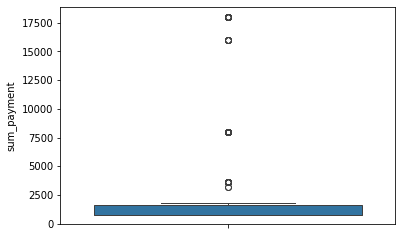

In [15]:
sns.boxplot(payments['sum_payment'])

In [16]:
# рассчитаем границы для выбросов
Q1 = np.percentile(payments['sum_payment'], 25)
Q3 = np.percentile(payments['sum_payment'], 75)
IQR = Q3 - Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR
print(lower_bound)
print(upper_bound)

-400.0
2800.0


In [17]:
payments_clean = payments.loc[payments['sum_payment']< upper_bound].copy()
payments_clean.head()

,id_user,training_type,sum_payment,date
0,1000,indiv,1800.0,2023-03-04
1,1000,indiv,1800.0,2023-03-21
2,1000,indiv,1800.0,2023-04-03
3,1000,indiv,1800.0,2023-04-12
4,1000,indiv,1800.0,2023-04-20


###  Агрегация данных

In [18]:
# создадим колонку год+месяц
payments_clean['mon'] = payments_clean['date'].dt.strftime('%Y-%m')
payments_clean.head()

,id_user,training_type,sum_payment,date,mon
0,1000,indiv,1800.0,2023-03-04,2023-03
1,1000,indiv,1800.0,2023-03-21,2023-03
2,1000,indiv,1800.0,2023-04-03,2023-04
3,1000,indiv,1800.0,2023-04-12,2023-04
4,1000,indiv,1800.0,2023-04-20,2023-04


In [19]:
pivot_pay  = pd.pivot_table(payments_clean,\
                            values='sum_payment', \
                            index=['id_user', 'mon'],\
                            columns='training_type',\
                            aggfunc=['count', 'sum'],\
                            fill_value=0).reset_index()
pivot_pay.head()

id_user      mon count         sum      
training_type                  group indiv group indiv
0                1000  2023-03     0     2     0  3600
1                1000  2023-04     0     4     0  7200
2                1000  2023-05     0     4     0  6400
3                1000  2023-06     0     2     0  3600
4                1000  2023-07     0     4     0  7200

In [20]:
pivot_pay.columns = ['id_user', 'mon', 'cnt_group', 'cnt_indiv', 'sum_group', 'sum_indiv']
pivot_pay['cnt_total'] = pivot_pay['cnt_group']+pivot_pay['cnt_indiv']
pivot_pay['sum_total'] = pivot_pay['sum_group']+pivot_pay['sum_indiv']
pivot_pay.head()

,id_user,mon,cnt_group,cnt_indiv,sum_group,sum_indiv,cnt_total,sum_total
0,1000,2023-03,0,2,0,3600,2,3600
1,1000,2023-04,0,4,0,7200,4,7200
2,1000,2023-05,0,4,0,6400,4,6400
3,1000,2023-06,0,2,0,3600,2,3600
4,1000,2023-07,0,4,0,7200,4,7200


## Анализ выручки и количества тренировок

In [21]:
p_gr = pivot_pay.groupby('mon')[['cnt_group', 'cnt_indiv', 'cnt_total', 'sum_group', 'sum_indiv', 'sum_total']].\
sum().reset_index()
p_gr.head()

,mon,cnt_group,cnt_indiv,cnt_total,sum_group,sum_indiv,sum_total
0,2023-01,1787,856,2643,1437600,1540800,2978400
1,2023-02,1804,920,2724,1447200,1656000,3103200
2,2023-03,1789,872,2661,1439200,1569600,3008800
3,2023-04,1955,720,2675,1572800,1296000,2868800
4,2023-05,1541,1320,2861,1242400,2116400,3358800


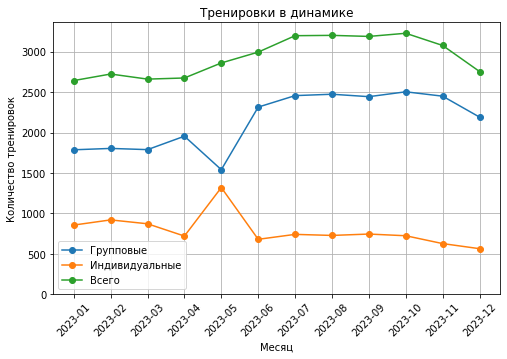

In [22]:
# динамика тренировок
plt.figure(figsize=(8, 5))
plt.plot(p_gr['mon'], p_gr['cnt_group'], marker='o', label='Групповые')
plt.plot(p_gr['mon'], p_gr['cnt_indiv'], marker='o', label='Индивидуальные')
plt.plot(p_gr['mon'], p_gr['cnt_total'], marker='o', label='Всего')
plt.xlabel('Месяц')
plt.ylabel('Количество тренировок')
plt.title('Тренировки в динамике')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)  # начинаем ось Y с нуля
plt.xticks(rotation=45)  # поворот подписей на оси X
plt.show()

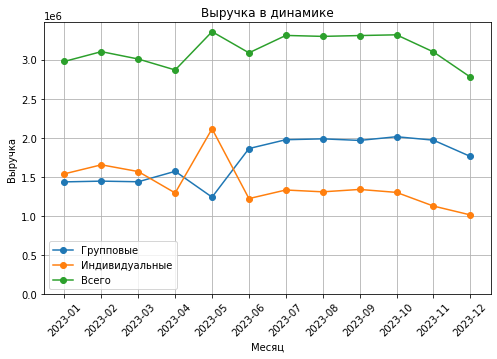

In [23]:
# динамика выручки
plt.figure(figsize=(8, 5))
plt.plot(p_gr['mon'], p_gr['sum_group'], marker='o', label='Групповые')
plt.plot(p_gr['mon'], p_gr['sum_indiv'], marker='o', label='Индивидуальные')
plt.plot(p_gr['mon'], p_gr['sum_total'], marker='o', label='Всего')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.title('Выручка в динамике')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)  # начинаем ось Y с нуля
plt.xticks(rotation=45)  # поворот подписей на оси X
plt.show()

### Расчет LT и LTR

In [24]:
# добавим колонки с первым и послденим месяцем занятий
pivot_pay['min_mon'] = pivot_pay.groupby('id_user')['mon'].transform('min')
pivot_pay['max_mon'] = pivot_pay.groupby('id_user')['mon'].transform('max')
pivot_pay.head()

,id_user,mon,cnt_group,cnt_indiv,sum_group,sum_indiv,cnt_total,sum_total,min_mon,max_mon
0,1000,2023-03,0,2,0,3600,2,3600,2023-03,2023-12
1,1000,2023-04,0,4,0,7200,4,7200,2023-03,2023-12
2,1000,2023-05,0,4,0,6400,4,6400,2023-03,2023-12
3,1000,2023-06,0,2,0,3600,2,3600,2023-03,2023-12
4,1000,2023-07,0,4,0,7200,4,7200,2023-03,2023-12


In [25]:
# рассчитаем средний и медианный LTR
pay_ltr = pivot_pay.groupby('id_user').agg(ltr = ('sum_total', 'sum')).reset_index()
print(round(pay_ltr['ltr'].mean(), 2))
print(round(pay_ltr['ltr'].median(), 2))

38720.95
30600.0


<Axes: xlabel='ltr', ylabel='Count'>

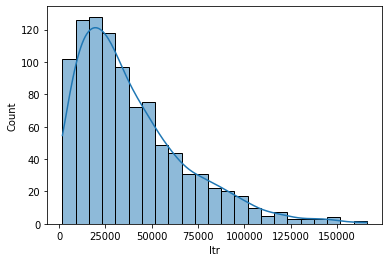

In [26]:
# распределение LTR
sns.histplot(pay_ltr['ltr'], kde = True)

In [27]:
# отбросим часть данных, где max_mon = декабрь 2023
clean_pay = pivot_pay.loc[pivot_pay['max_mon']!='2023-12']
print(len(pivot_pay))
print(len(clean_pay))

5293
2558


In [28]:
# рассчитаем ltr на оставшихся данных
clean_gr = clean_pay.groupby('id_user').agg(ltr = ('sum_total', 'sum')).reset_index()

In [29]:
print(round(clean_gr['ltr'].mean(), 2))
print(round(clean_gr['ltr'].median(), 2))

32637.21
25600.0


In [30]:
# теперь отфильтруем данные по min_mon и оставим самые ранние когорты
clean_pay2 = pivot_pay.loc[pivot_pay['min_mon'].isin(['2023-01', '2023-02', '2023-03', '2023-04'])]
print(len(pivot_pay))
print(len(clean_pay2))

5293
4165


In [31]:
#снова посчитаем LTR
clean_gr2 = clean_pay2.groupby('id_user').agg(ltr = ('sum_total', 'sum')).reset_index()

In [32]:
print(round(clean_gr2['ltr'].mean(), 2))
print(round(clean_gr2['ltr'].median(), 2))

43927.63
36000.0


In [33]:
#рассчитаем LT
p_group = clean_pay2.groupby('id_user').agg(nmon = ('id_user', 'count')).reset_index()
print(p_group['nmon'].mean())
print(p_group['nmon'].median())

6.253753753753754
7.0


In [34]:
print(f"среднее количество месяцев посещений фитнес-клуба: {round(p_group['nmon'].mean(), 2)} месяцев")

среднее количество месяцев посещений фитнес-клуба: 6.25 месяцев


###  Анализ маркетинговой акции

In [35]:
cnt_ind_apr = p_gr.loc[p_gr['mon'] == '2023-04', 'cnt_indiv'].iloc[0]
cnt_gr_apr = p_gr.loc[p_gr['mon'] == '2023-04', 'cnt_group'].iloc[0]
cnt_ind_may = p_gr.loc[p_gr['mon'] == '2023-05', 'cnt_group'].iloc[0]
cnt_gr_may = p_gr.loc[p_gr['mon'] == '2023-05', 'cnt_indiv'].iloc[0]
cnt_ind_june = p_gr.loc[p_gr['mon'] == '2023-06', 'cnt_indiv'].iloc[0]
cnt_gr_june = p_gr.loc[p_gr['mon'] == '2023-06', 'cnt_group'].iloc[0]

In [36]:
#факт.выручка за май
rev_fact_may = p_gr.loc[p_gr['mon'] == '2023-05', 'sum_total'].iloc[0]

In [37]:
#гипотетическая выручка за май
rev_hyp_may = (cnt_ind_apr+cnt_ind_june)*0.5*1800 + (cnt_gr_apr+cnt_gr_june)*0.5*800 

In [38]:
print(rev_fact_may)
print(rev_hyp_may)

3358800
2968000.0


In [39]:
print(f"прирост выручки из-за проведения акции составил:{rev_fact_may-rev_hyp_may} руб.")

прирост выручки из-за проведения акции составил:390800.0 руб.


In [40]:
# факт.прибыль за май
prof_fact_may = p_gr.loc[p_gr['mon'] == '2023-05', 'cnt_indiv'].iloc[0]*(1600-800)+\
p_gr.loc[p_gr['mon'] == '2023-05', 'cnt_group'].iloc[0]*(800-200)

In [41]:
#гипотетическая прибыль за май
prof_hyp_may = (cnt_ind_apr+cnt_ind_june)*0.5*(1800-800) + (cnt_gr_apr+cnt_gr_june)*0.5*(800-200) 

In [42]:
print(f"прирост прибыли из-за проведения акции составил:{prof_fact_may-prof_hyp_may} руб.")

прирост прибыли из-за проведения акции составил:-400.0 руб.
